In [1]:
# Step 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import xgboost as xgb

In [2]:
# Step 2: Load Data
df = pd.read_csv('../data/online_retail.csv', encoding='ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Step 3: Data Cleaning
df.dropna(subset=['CustomerID'], inplace=True)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [4]:
# Step 4: Feature Engineering
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

clv_data = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',                  # Frequency
    'InvoiceDate': lambda x: (snapshot_date - x.min()).days,  # Recency
    'TotalPrice': 'sum'                      # Monetary
})

clv_data.rename(columns={
    'InvoiceNo': 'Frequency',
    'InvoiceDate': 'Recency',
    'TotalPrice': 'Monetary'
}, inplace=True)

# Target Variable: CLV
clv_data['CLV'] = clv_data['Monetary']

In [5]:
# Step 5: Model Preparation
X = clv_data[['Frequency', 'Recency', 'Monetary']]
y = clv_data['CLV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# Model Training
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [7]:
# Step 7: Evaluation
y_pred = model.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R² Score: 0.9344249033906076
RMSE: 2591.852348945225


In [8]:
# Step 8: Save the model
joblib.dump(model, '../app/model.pkl')

['../app/model.pkl']

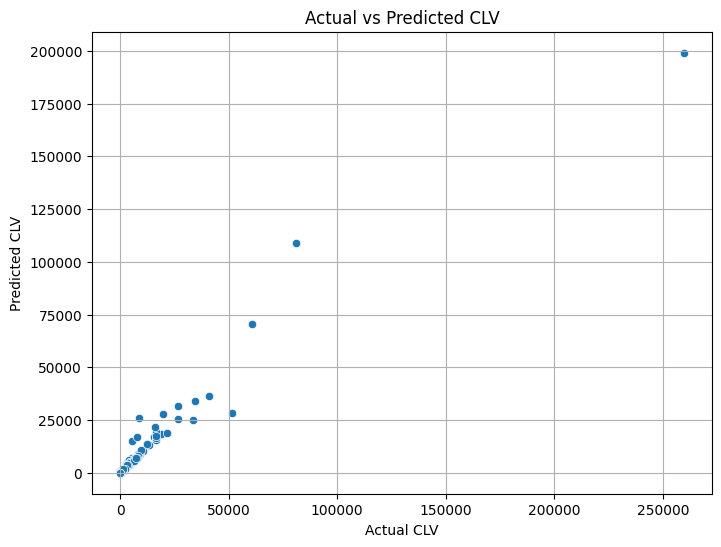

In [9]:
# Optional: Visualizations
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Actual vs Predicted CLV')
plt.grid(True)
plt.show()